# EDA for MRC train data

train은 data 전처리 후, 그대로 tokenizer 사용

inference 시 같은 data 전처리 후, add speical token 후 tokneizer 사용

wiki 데이터는 같은 context 전처리 후, mecab을 이용한 tokenize는? 어떨까?

---

**context 개행문자(\\n, ; 등) -> answer 시작부분 기준으로 건드리기** -> 개행문자 제거 (wiki 데이터도 포함)

**train과 wiki data에 title이 있는데 마지막 context 부분에 더하는 방법** -> train data의 title과 context 유사도 측정(50%는 제일 유사함)

---

**train data는 answers, context, document_id, id, question, title columns 존재** -> 3952개 존재

In [1]:
from datasets import load_from_disk

train = load_from_disk('/opt/ml/data/train_dataset/train')
train

Dataset({
    features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 3952
})

title, context, question, answers를 자세히 조사해보자

In [2]:
train[0]

{'title': '미국 상원',
 'context': '미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05',
 'question': '대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?',
 'id': 'mrc-1-000067',
 'answers': {'answer_start'

**wiki 데이터는 text, title 존재** -> 60613개 존재

In [2]:
import os
import json
data_path="../data/"
context_path= "wikipedia_documents.json"
with open(os.path.join(data_path, context_path), "r", encoding="utf-8") as f:
    wiki = json.load(f)

# 1. train데이터의 Title

### **title insight: 내가 알기론 train 시, title column을 안 쓰는거 같은데 context 마지막에 title 단어를 붙이면 어떨까? (wiki data도 포함)**

### context와 question이 한글인데, title은 영어인 경우도 존재!! -> 이런 경우는 어떻게 하면 좋을까? (ex) title만 번역 or 이 경우만 context 뒤에 title 안 붙이기)

### title이 긴 경우도 존재하므로(최대 단어 24개 가지고 있음) mecab으로 자르고 context 마지막에 붙인다면?


## 1-1. title 최대, 최소 길이

### 제일 작은 title length 길이 1, 가장 긴 title length 길이 57

In [45]:
title_len = [len(i) for i in train['title']]
print(max(title_len))
print(min(title_len))

57
1


## 1-2. title 길이 분포도

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


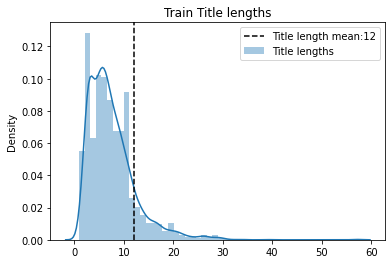

 가장 긴 제목은 57 개의 단어를, 평균 제목 길이는 7.511386639676114 개의 단어를, 가장 짧은 제목은 1 개의 단어를 가지고 있습니다.


In [46]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['title'])

tt['title_len'] = [len(i) for i in train['title']]

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.title_len.mean() + dataframe.title_len.std()).astype(int)
    sns.distplot(tuple(dataframe.title_len), hist=True, kde=True, label='Title lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Title length mean:{max_seq_len}')
    plt.title('Train Title lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 제목은 {tt['title_len'].max()} 개의 단어를, 평균 제목 길이는 {tt['title_len'].mean()} 개의 단어를, 가장 짧은 제목은 {tt['title_len'].min()} 개의 단어를 가지고 있습니다.")
plot_doc_lengths(tt)

## 1-3. title의 단어 갯수 분포도

In [5]:
from konlpy.tag import Mecab

mecab = Mecab()
def tokenize(text):
    return mecab.morphs(text)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


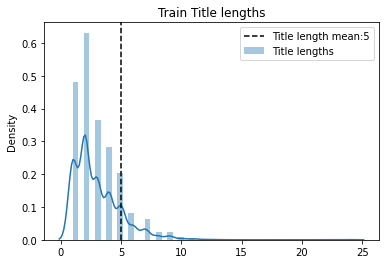

 가장 많은 단어 분포 제목은 24 개의 단어를, 평균 단어 분포 제목은 3.0080971659919027 개의 단어를, 가장 적은 단어 제목은 1 개의 단어를 가지고 있습니다.


In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['title'])
count_words_f = lambda x: len(tokenize(x))

tt['title_len'] = list(map(count_words_f, train['title']))

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.title_len.mean() + dataframe.title_len.std()).astype(int)
    sns.distplot(tuple(dataframe.title_len), hist=True, kde=True, label='Title lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Title length mean:{max_seq_len}')
    plt.title('Train Title lengths')
    plt.legend()
    plt.show()
    print(f" 가장 많은 단어 분포 제목은 {tt['title_len'].max()} 개의 단어를, 평균 단어 분포 제목은 {tt['title_len'].mean()} 개의 단어를, 가장 적은 단어 제목은 {tt['title_len'].min()} 개의 단어를 가지고 있습니다.")
plot_doc_lengths(tt)

## 1-4. title길이가 1인 경우는 머일까?

### title 길이가 1인 경우: '힐', '톳' -> '힐'은 context나 question에서 사람이름으로 나온다, '톳'은 먹는 톳이로 context 존재

In [47]:
short_title=[]
short_title_index=[]
for i,z in enumerate(train['title']):
    if len(z)==1:
        short_title_index.append(i)
        short_title.append(z)

In [48]:
train[short_title_index[1]]

{'title': '톳',
 'context': '한국, 일본, 중국 등지에서 식용으로 이용되고 있다. 특히 일본에서 아주 선호했으며, 수세기 전부터 먹어왔다. 일본 음식점과 웰빙의 영향으로, 영국과 북아메리카 등지에서도 수입해서 먹고 있다.\\n\\n\\n식이섬유 (톳)이란\\n\\n조간대 하부에서 큰 군락을 이룬다. 식물체는 섬유상의 뿌리를 가지고 직립하며 줄기는 원주상이고 1회 우상으로 가지가 갈라지며 보통 10∼60cm 이상 자란다. \\n\\n가지 중 작은 것은 곤봉 모양을 하며 얼핏 보아 잎과 같이 느껴진다. \\n\\n\\n청정해 완도및 서남해(남해안일대)에서 자연산과 양식으로 생산되는 갈조식물이다.\\n\\n톳에는 칼슘,철,인,요소등의 미네날과 식이섬유가 풍부하다.\\n\\n고기등 육류와 함께먹으면 고기에 부족한 식이섬유를 보충해주기 때문에 영양에도 좋고 맛도 좋을 뿐 아니라 신선한 톳이 육류의 느끼함을 확! 없애준다. \\n\\n식량이 많이 부족했던 보릿고개엔 구황용으로 곡식을 조금 섞어서 톳밥을 지어 먹기도 했었다.\\n\\n하지만 톳은 일본 사람들이 아주 좋아해서 한때는 전량 일본으로 수출되었다.\\n\\n톳이 성장기 어린이들에게 특별히 좋은 이유는 철분, 칼슘, 요오드 등 무기질이 풍부하기 때문이다.\\n\\n철분은 체내의 영양흡수율이 겨우 10%밖에 되지 않을 정도로 낮아서 항상 부족하기 쉬운 영양소이므로 톳을 이용해 톳유부영양밥이나 톳멸치볶음 같은 음식을 만들면 훌륭한 건강식이 된다.',
 'question': '식량이 부족한 시기를 어떻게 표현하는가?',
 'id': 'mrc-0-001563',
 'answers': {'answer_start': [447], 'text': ['보릿고개']},
 'document_id': 21365,
 '__index_level_0__': 1026}

## 1-5. title길이가 20 이상의 경우는 머일까?

title 길이 분포도를 보면, 길이가 20 넘어가는 경우는 적지만 max는 57로 찍힌다. 과연, title 길이 20이상의 경우는 어떤 경우일까?

---

### context와 question이 한글인데, title은 영어인 경우도 존재!! -> 이런 경우는 어떻게 하면 좋을까? (ex) title만 번역 or 이 경우만 context 뒤에 title 안 붙이기)

ex) train index 107번 -> title(Someone Saved My Life Tonight) -> 번역 시 context 안 겹침

ex) train index 205번 -> title(The Impossible Planet) -> 번역 시, Planet(행성)의 경우 context와 많이 겹침!

---

### title이 긴 경우는 Mecab으로 잘라서 쓴다면, 어떨까? -> 사용시 괄호 경우 제거도 괜찮?

mecab으로 자르면, title index 138번 경우 -> 다스부르고테셴을 [다스, 부르고, 테셴]으로 자르는데 '테셴'이라는 단어가 context에 겹쳐준다.

In [49]:
long_title=[]
long_title_index=[]
for i,z in enumerate(train['title']):
    if len(z)>=20:
        long_title_index.append(i)
        long_title.append(z)

In [50]:
train[long_title_index[8]]

{'title': '게오르크 프리드리히 폰 브란덴부르크안스바흐 변경백',
 'context': '1561년 4월 23일부터는 폴란드의 크르노프 내에 자신의 이름을 딴 도시 게오르크부르크를 건설했다. 근처의 야산에서 광산을 채굴케 하여 지역의 자체 소득원을 만드는 한편, 소금 무역 시장과 양조장, 정원이 있는 주점 등을 건설하여 도시의 소득원을 자체적으로 확보할 수 있게 했다. 게오르크 프리드리히의 궁정은 르네상스 시대 신성 로마 제국의 가장 인상적인 궁정의 하나였다. 하지만 1552년과 1554년의 마르그라베 전투 기간 중 모두 파괴되었다. 그밖에 게오르크 프리드리히는 뷀츠부르크와 바이로이트에 궁정을 소유하고 있었다.\\n\\n1577년 우울증이 심화되면서 정신질환을 겪게 된 사촌동생 알브레히트 프리드리히 폰 호엔촐레른의 가까운 친척 자격으로 프로이센 공국의 섭정을 맡았다. 그의 섭정직에 대해 폴란드 왕국 내에서의 일부 반발은 있었지만 그는 1578년 폴란드의 국왕 스테판 바토리에 의해 섭정직을 공인받았다. 1578년 게오르크 프리드리히는 바르샤바로 가서 폴란드의 국왕에 대한 충성을 맹약하였다. 그는 폴란드 왕 스테판 바토리의 협력을 얻어 프로이센 공국 내에서의 영주의 권한을 강화하고, 관료 채용은 폴란드어와 독일어를 모두 구사할 줄 아는 자를 채용하되 직접 선발하는 등의 개혁을 실시했다. 또한 프랑켄 지역의 관료들을 프로이센 공국으로 보내, 행정 실무, 금융 정책, 조세 정책, 행정 관리 등의 제도를 프랑켄 지역을 모델로 하여 프로이센 정치에 적용하였다.\\n\\n1577년 그는 루터교회의 콩고드 협약에 정식 서명하고, 1580년 이를 성문화하여 법전인 콩고드의 책을 편찬하였다. 1580년 9월 18일에는 신성 로마 제국 황제이자 보헤미아의 왕을 겸한 루돌프 2세로부터 관세와 통행세를 면제받을 권한을 부여받았다. 1603년 게오르크 프리드리히는 안스바흐에서 사망하여, 호엔촐레른 가문의 묘소가 있는 안스바흐 하일스브룬 수도원에 묻혔다.',
 'question'

In [194]:
long_title_index[5]

205

In [2]:
from konlpy.tag import Mecab
mecab = Mecab()
def tokenize(text):
    return mecab.morphs(text)

In [52]:
tokenize(train[long_title_index[8]]['title'])

['게오르크', '프리드리히', '폰', '브란덴부르크', '안', '스', '바흐', '변경백']

## 1-6. title과 context 의 유사도를 알아보자!

### 목적: 각 index의 title과 context 마다 유사도가 제일 높다면, context 뒤에 title을 붙여도 되지 않을까?

### 각 index의 context에 최대 유사도가 index에 맞는 title은 50%이다. -> 그냥 모든 title을 context 뒤에 붙여도 되고 최대 유사도 50% title만 붙여도 좋을 듯 하다!

### 겹치는 title이 약 1200개 정도 겹치고 겹치는 contexts는 612개이다. (mecab만 적용)

### 50%만 유사한 이유는 같은 제목이 존재! -> 그러므로, 모든 title을 context에 붙여도 될듯?

In [14]:
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

model_checkpoint = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

context 유사도 적용

In [48]:
pre_contexts=list(map(tokenize,train['context'])) #mecab 적용

In [49]:
contexts=[]
for item in pre_contexts:
    k=''
    for i in item:
        k+=i+" "
    contexts.append(k.strip())

In [67]:
print("중복 제거한 contexts 개수: ",len(set(contexts)))
print("중복 제거 안 한 context 개수: ",len(contexts))

중복 제거한 contexts 개수:  3340
중복 제거 안 한 context 개수:  3952


In [350]:
tokenizer_func = lambda x: tokenizer.tokenize(x) #roberta-large tokenize

In [351]:
vectorizer = TfidfVectorizer(
    tokenizer=tokenizer_func,
    ngram_range=(1,2)
)

In [352]:
vectorizer.fit(contexts)
sp_matrix = vectorizer.transform(contexts)

title 임베딩하기

In [53]:
pre_titles = list(map(tokenize,train['title'])) #mecab 적용

In [54]:
titles=[]
for item in pre_titles:
    k=''
    for i in item:
        k+=i+" "
    titles.append(k.strip())

In [55]:
print("중복 제거한 title 개수: ",len(set(titles)))
print("중복 제거 안 한 title 개수: ",len(titles))

중복 제거한 title 개수:  2716
중복 제거 안 한 title 개수:  3952


In [355]:
titles_vec = vectorizer.transform(titles)

In [356]:
result = titles_vec * sp_matrix.T
result.shape # title - contexts -> 가정은 각 title index i와 contexts index i와 가장 유사해야된다!

(3952, 3952)

In [364]:
result = result.toarray()

In [377]:
index_matching=0
index_not_matching=0
for inx,_ in enumerate(result):
    maxindex = np.argsort(-result[inx])
    if inx==maxindex[0]:
        index_matching+=1
    else:
        index_not_matching+=1

In [378]:
print("각 index에 대한 context와 가장 유사도가 높은 title이 같은 index인 갯수: ",index_matching)
print("각 index에 대한 context와 가장 유사도가 높은 title이 같은 index가 아닌 갯수: ",index_not_matching)

각 index에 대한 context와 가장 유사도가 높은 title이 같은 index인 갯수:  1970
각 index에 대한 context와 가장 유사도가 높은 title이 같은 index가 아닌 갯수:  1982


## 1-7. title과 question의 유사도를 알아보자!

question 유사도 적용

In [15]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [16]:
tokenizer_func = lambda x: tokenizer.tokenize(x) #roberta-large tokenize

In [17]:
pre_questions=list(map(tokenize,train['question'])) #mecab 적용

In [18]:
questions=[]
for item in pre_questions:
    k=''
    for i in item:
        k+=i+" "
    questions.append(k.strip())

In [19]:
vectorizer = TfidfVectorizer(
    tokenizer=tokenizer_func,
    ngram_range=(1,2)
)
vectorizer.fit(questions)

/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(ngram_range=(1, 2),
                tokenizer=<function <lambda> at 0x7f1d0c3db9d0>)

In [20]:
sp_matrix = vectorizer.transform(questions)

title 임베딩하기

In [21]:
pre_titles = list(map(tokenize,train['title'])) #mecab 적용

In [22]:
titles=[]
for item in pre_titles:
    k=''
    for i in item:
        k+=i+" "
    titles.append(k.strip())

In [23]:
titles_vec = vectorizer.transform(titles)

In [24]:
result = titles_vec * sp_matrix.T
result.shape # title - contexts -> 가정은 각 title index i와 contexts index i와 가장 유사해야된다!

(3952, 3952)

In [25]:
result = result.toarray()

In [28]:
index_matching=0
index_not_matching=0
for inx,_ in enumerate(result):
    maxindex=np.argsort(-result[inx])
    if inx==maxindex[0]:
        index_matching+=1
    else:
        index_not_matching+=1

In [29]:
print("각 index에 대한 question과 가장 유사도가 높은 title이 같은 index인 갯수: ",index_matching)
print("각 index에 대한 question과 가장 유사도가 높은 title이 같은 index가 아닌 갯수: ",index_not_matching)

각 index에 대한 question과 가장 유사도가 높은 title이 같은 index인 갯수:  1172
각 index에 대한 question과 가장 유사도가 높은 title이 같은 index가 아닌 갯수:  2780


## 1-8. 한영을 제외한 특수문자 및 문자 - context

mecab 적용

In [38]:
pre_contexts=list(map(tokenize,train['context'])) #mecab 적용
contexts=[]
for item in pre_contexts:
    k=''
    for i in item:
        k+=i+" "
    contexts.append(k.strip())

In [39]:
import re
special_character=[]
text=contexts
for l in text:
    tmp = []
    l=re.compile('[|가-힣A-Z0-9]+').sub('',l)
    for c in l:
        if 'n'==c and len(tmp)!=0:
            tmp[len(tmp)-1]=tmp[len(tmp)-1]+'n'
        else:
            nn = re.compile('[|a-z]+').sub('',c)
            if nn !=" " and nn!="":
                tmp.append(nn)
    special_character.append(set(tmp))

In [47]:
special_character[3]

{'(', ')', ',', '.', '\\n', '∼', '佛', '光', '冠', '背', '龕'}

# 2. wiki 데이터의 title

## 2-1. wiki title 최대, 최소 길이

### 제일 작은 title length 길이 1, 가장 긴 title length 길이 96

### train wiki data에 비해 wiki title data의 길이나 단어 갯수는 약 2배 정도 차이난다. 하지만 분포도는 매우 유사하다. (둘 다 제목 길이 20이상부터 매우 적음)

In [35]:
title_len = []
for idx, i in enumerate(wiki):
    title_len.append(len(wiki[str(idx)]['title']))

In [37]:
print(max(title_len))
print(min(title_len))

96
1


## 2-2. title 길이 분포도

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


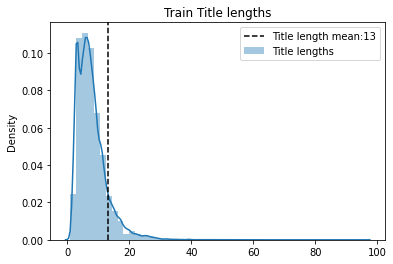

 가장 긴 제목은 96 개의 길이를, 평균 제목 길이는 7.801676208074175 개의 길이를, 가장 짧은 제목은 1 개의 길이를 가지고 있습니다.


In [39]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['title'])

tt['title_len'] = title_len

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.title_len.mean() + dataframe.title_len.std()).astype(int)
    sns.distplot(tuple(dataframe.title_len), hist=True, kde=True, label='Title lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Title length mean:{max_seq_len}')
    plt.title('Train Title lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 제목은 {tt['title_len'].max()} 개의 길이를, 평균 제목 길이는 {tt['title_len'].mean()} 개의 길이를, 가장 짧은 제목은 {tt['title_len'].min()} 개의 길이를 가지고 있습니다.")
plot_doc_lengths(tt)

## 2-3. title의 단어 갯수 분포도

In [40]:
from konlpy.tag import Mecab

mecab = Mecab()
def tokenize(text):
    return mecab.morphs(text)

In [41]:
title_word_len = []
for idx, i in enumerate(wiki):
    title_word_len.append(len(tokenize(wiki[str(idx)]['title'])))

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


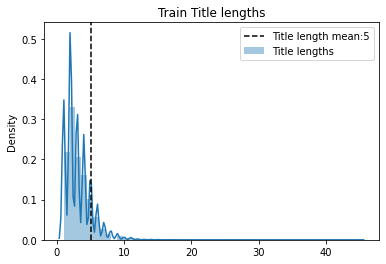

 가장 많은 단어 분포 제목은 45 개의 단어를, 평균 단어 분포 제목은 3.0928348704073385 개의 단어를, 가장 적은 단어 제목은 1 개의 단어를 가지고 있습니다.


In [42]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['title'])

tt['title_len'] = title_word_len

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.title_len.mean() + dataframe.title_len.std()).astype(int)
    sns.distplot(tuple(dataframe.title_len), hist=True, kde=True, label='Title lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Title length mean:{max_seq_len}')
    plt.title('Train Title lengths')
    plt.legend()
    plt.show()
    print(f" 가장 많은 단어 분포 제목은 {tt['title_len'].max()} 개의 단어를, 평균 단어 분포 제목은 {tt['title_len'].mean()} 개의 단어를, 가장 적은 단어 제목은 {tt['title_len'].min()} 개의 단어를 가지고 있습니다.")
plot_doc_lengths(tt)

## 2-4. title 길이가 20이상은 경우는 뭘까?

### train data와 같이, context와 question이 한글인데, title은 영어인 경우도 존재!! -> 이런 경우는 어떻게 하면 좋을까? (ex) title만 번역 or 이 경우만 context 뒤에 title 안 붙이기)

In [3]:
long_title=[]
long_title_index=[]
for idx,z in enumerate(wiki):
    if len(wiki[str(idx)]['title'])>=20:
        long_title_index.append(str(idx))

In [10]:
wiki[long_title_index[70]]

{'text': '7101호부터 7120호까지의 차량은 1975년 12월 미국수출입은행(EXIM) 차관으로 도입하였으며, 7121호부터 7140호까지의 차량은 같은 차관을 통하여 1978년 8월 들여왔다.  이 가운데 일부 차량(7111 ~ 7120)은 한국철도공사 7500호대 디젤 기관차에서 개조·편입되었다.\n\n이후의 차량은 현대차량에서 국산화 제작하여 납품하게 되었다. 1980년 12월에 4량, 이듬해 12월 5량, 1982년 12월에 9량이 도입되었다.  계속하여 1983년과 이듬해 12월에 각 10량이, 1985년 1월, 12월에 12량이 운행을 개시하였다.  특히 7179~7190호의 12량은 운용과 검수의 문제를 보완하기 위하여 전기 회로의 결선(結線) 구조를 보완하여 도입되었다',
 'corpus_source': '위키피디아',
 'url': None,
 'domain': None,
 'title': '한국철도공사 7100호대 디젤 기관차',
 'author': None,
 'html': None,
 'document_id': 10257}

## 2-5. title과 context 의 유사도를 알아보자!

### 각 index에 대한 context과 가장 유사도가 높은 title이 같은 index인 갯수는 60613개 중에, 18599개이다.

### 하지만!, 중복 제거한 title 개수가 31753개로 약 30000개가 겹치므로 이러한 현상이 일어나는 것을 발견함!

### 그래서, 전체 각 title을 context 뒤에 붙여도 되고, 높은 18599개만 context 뒤에 붙여도 될듯하다

contexts 임베딩

In [11]:
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

model_checkpoint = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [12]:
from konlpy.tag import Mecab
mecab = Mecab()
def tokenize(text):
    return mecab.morphs(text)

In [15]:
pre_contexts=[]
for idx,z in enumerate(wiki):
    pre_contexts.append(tokenize(wiki[str(idx)]['text']))

In [17]:
contexts=[]
for item in pre_contexts:
    k=''
    for i in item:
        k+=i+" "
    contexts.append(k.strip())

In [19]:
tokenizer_func = lambda x: tokenizer.tokenize(x) #roberta-large tokenize

In [20]:
vectorizer = TfidfVectorizer(
    tokenizer=tokenizer_func,
    ngram_range=(1,2)
)

In [21]:
vectorizer.fit(contexts)
sp_matrix = vectorizer.transform(contexts)

/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
Token indices sequence length is longer than the specified maximum sequence length for this model (1148 > 512). Running this sequence through the model will result in indexing errors


title 임베딩

In [22]:
pre_titles=[]
for idx,z in enumerate(wiki):
    pre_titles.append(tokenize(wiki[str(idx)]['title']))

In [23]:
titles=[]
for item in pre_titles:
    k=''
    for i in item:
        k+=i+" "
    titles.append(k.strip())

In [35]:
print("중복 제거한 title 개수: ",len(set(titles)))
print("중복 제거 안 한 title 개수: ",len(titles))

중복 제거한 title 개수:  31753
중복 제거 안 한 title 개수:  60613


In [24]:
titles_vec = vectorizer.transform(titles)

In [25]:
result = titles_vec * sp_matrix.T
result.shape # title - contexts -> 가정은 각 title index i와 contexts index i와 가장 유사해야된다!

(60613, 60613)

In [26]:
result = result.toarray()

In [28]:
import numpy as np
index_matching=0
index_not_matching=0
for inx,_ in enumerate(result):
    maxindex = np.argsort(-result[inx])
    if inx==maxindex[0]:
        index_matching+=1
    else:
        index_not_matching+=1

In [36]:
print("각 index에 대한 context와 가장 유사도가 높은 title이 같은 index인 갯수: ",index_matching)
print("각 index에 대한 context와 가장 유사도가 높은 title이 같은 index가 아닌 갯수: ",index_not_matching)

각 index에 대한 context와 가장 유사도가 높은 title이 같은 index인 갯수:  18599
각 index에 대한 context와 가장 유사도가 높은 title이 같은 index가 아닌 갯수:  42014


# 3. train data의 context

## 3-1. context 최대, 최소 길이

### 제일 작은 context length 길이 512, 가장 긴 context length 길이 2059

In [39]:
# context 단어 분포 길이, context 길이 확인
context_len = [len(i) for i in train['context']]
print(max(context_len))
print(min(context_len))

2059
512


## 3-2. context 길이 분포도

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


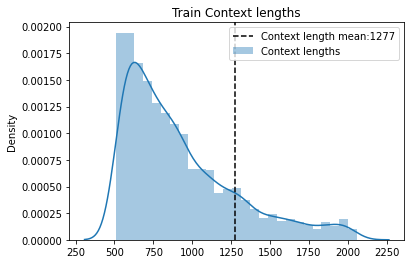

 가장 긴 text는 2059 개의 길이를, 평균 context 길이는 920.2206477732793 개의 길이를, 가장 짧은 context는 512 개의 길이를 가지고 있습니다.


In [41]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['context'])

tt['context_len'] = [len(i) for i in train['context']]

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.context_len.mean() + dataframe.context_len.std()).astype(int)
    sns.distplot(tuple(dataframe.context_len), hist=True, kde=True, label='Context lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Context length mean:{max_seq_len}')
    plt.title('Train Context lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 text는 {tt['context_len'].max()} 개의 길이를, 평균 context 길이는 {tt['context_len'].mean()} 개의 길이를, 가장 짧은 context는 {tt['context_len'].min()} 개의 길이를 가지고 있습니다.")
plot_doc_lengths(tt)

## 3-3. context 단어 갯수 분포도

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


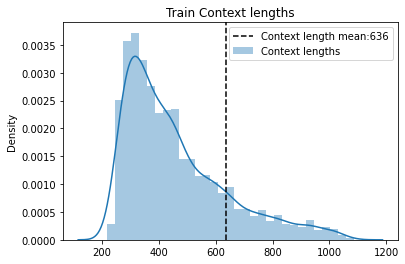

 가장 긴 text는 1085 개의 단어 갯수를, 평균 text 길이는 457.4741902834008 개의 단어 갯수를, 가장 짧은 text는 218 개의 단어를 가지고 있습니다.


In [97]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['context'])
count_words_f = lambda x: len(tokenize(x))

tt['context_len'] = list(map(count_words_f, train['context']))

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.context_len.mean() + dataframe.context_len.std()).astype(int)
    sns.distplot(tuple(dataframe.context_len), hist=True, kde=True, label='Context lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Context length mean:{max_seq_len}')
    plt.title('Train Context lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 text는 {tt['context_len'].max()} 개의 단어 갯수를, 평균 text 길이는 {tt['context_len'].mean()} 개의 단어 갯수를, 가장 짧은 text는 {tt['context_len'].min()} 개의 단어를 가지고 있습니다.")
plot_doc_lengths(tt)

## 3-4. context 길이가 2000이상은 경우는 뭘까?

In [43]:
long_context=[]
long_context_index=[]
for i,z in enumerate(train['context']):
    if len(z)>=2000:
        long_context_index.append(i)
        long_context.append(z)

In [61]:
train[long_context_index[20]]

{'title': '박창암',
 'context': '본관은 밀양(密陽). 함경남도 북청에서 출생하였으며 지난날 한때 함경남도 단천에서 잠시 유아기를 보낸 적이 있다. 만주국립연길(간도)사범학교를 졸업하고 간도의 조양천(朝陽川)초등학교에서 교사를 하다 1943년 만주국 군대인 간도특설대에 입대했다. 간도특설대는 만주국 북부에 있던 사회주의 계열 민족 해방세력인 팔로군, 동북항일연군, 조선의용대와 만주 북서부에 잔존해 있던 대한독립군단을 토벌하기 위한 특수 목적을 띈 독립군 토벌 부대였다. 간도특설대가 살해한 항일무장세력과 민간인은 172명에 달한다. 강간·약탈·고문을 당한 이들도 적잖다. \\n\\n광복 후 그는 평양에서 협신(協新)공업학교 교사를 하다 서울로 옮겨 1949년 육군 중위로 임관해 6·25전쟁을 치르게 됐다. 전쟁 중 그는 빨치산을 토벌하는 작전과 대북 심리전 분야에 주로 참여했다. 한국전쟁 당시 8사단 수색대장과 동해유격대장, 육군 특수부대장을 지냈으며, 60년 육군사관학교 생도대장을 역임했다. 이러한 그가 세인의 주목을 받게 된 것은 1961년 박정희 소장이 주도한 5·16군사정변에 참여하면서다. 박정희, 장도영 등과 함께 5·16 군사 정변에 가담하였으나 알래스카 토벌 작전으로 숙청되었다. 육군 준장으로 예편하였다. 그는 5·16에 주체세력으로 참여해 구정권의 부패를 날리는 서슬 시퍼런 ‘혁명검찰부’의 부장을 맡았다.\\n\\n그는 혁명검찰부장으로 활동할 당시 장도영 국가재건최고회의 의장을 반혁명 음모 혐의로 구속, 군사재판에 회부하기도 했다. 그러나 63년 2월 혁명검찰부장을 그만두고 준장으로 예편하자마자 본인이 오히려 반혁명 혐의로 구속되는 ‘인생유전’을 겪었다. 1963년 3월11일 김재춘씨가 이끄는 중앙정보부는 그가 반혁명사건에 연루된 인물이라고 발표했다. 중앙정보부는 5·16 당일 박정희 소장과 함께 해병대를 이끌고 한강 인도교를 건너 쿠데타를 성공시킨 김동하 예비역 해병대 중장과 박임항 예비역 육군 중장, 이규광 예비역 육군 준장

## 3-5. contexts 겹치는 갯수 확인

### context 겹치는 갯수는 총 3962개 중에, 612개이다. (mecab 적용)

In [66]:
print("중복 제거한 context 개수: ",len(set(contexts)))
print("중복 제거 안 한 context 개수: ",len(contexts))

중복 제거한 context 개수:  3340
중복 제거 안 한 context 개수:  3952


# 4. train data의 question

## 4-1. question 최대, 최소 길이는 78, 8이다.

In [68]:
title_len = [len(i) for i in train['question']]
print(max(title_len))
print(min(title_len))

78
8


## 4-2. question 길이 분포

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


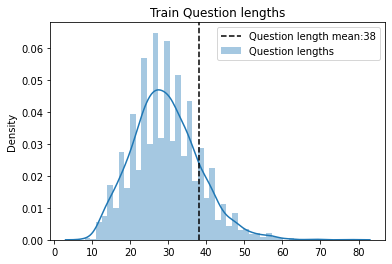

 가장 긴 질문은 78 개의 길이를, 평균 질문 길이는 29.32236842105263 개의 길이를, 가장 짧은 질문은 8 개의 길이를 가지고 있습니다.


In [69]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['question'])

tt['question_len'] = [len(i) for i in train['question']]

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.question_len.mean() + dataframe.question_len.std()).astype(int)
    sns.distplot(tuple(dataframe.question_len), hist=True, kde=True, label='Question lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Question length mean:{max_seq_len}')
    plt.title('Train Question lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 질문은 {tt['question_len'].max()} 개의 길이를, 평균 질문 길이는 {tt['question_len'].mean()} 개의 길이를, 가장 짧은 질문은 {tt['question_len'].min()} 개의 길이를 가지고 있습니다.")
plot_doc_lengths(tt)

## 4-3. question 단어 갯수 분포

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


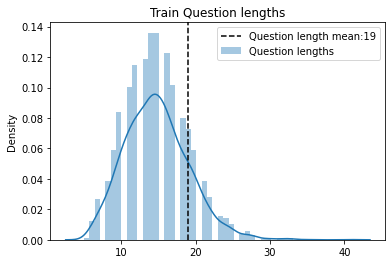

 가장 많은 단어 분포 제목은 41 개의 단어를, 평균 단어 분포 제목은 14.773785425101215 개의 단어를, 가장 적은 단어 제목은 5 개의 단어를 가지고 있습니다.


In [71]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['question'])
count_words_f = lambda x: len(tokenize(x))

tt['title_len'] = list(map(count_words_f, train['question']))

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.title_len.mean() + dataframe.title_len.std()).astype(int)
    sns.distplot(tuple(dataframe.title_len), hist=True, kde=True, label='Question lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Question length mean:{max_seq_len}')
    plt.title('Train Question lengths')
    plt.legend()
    plt.show()
    print(f" 가장 많은 단어 분포 제목은 {tt['title_len'].max()} 개의 단어를, 평균 단어 분포 제목은 {tt['title_len'].mean()} 개의 단어를, 가장 적은 단어 제목은 {tt['title_len'].min()} 개의 단어를 가지고 있습니다.")
plot_doc_lengths(tt)

## 4-4. question 단어 분포가 20 이상의 경우는 머일까?

In [75]:
long_question_index=[]
for i,z in enumerate(train['question']):
    k=list(tokenize(train['question'][i]))
    if len(k)>=20:
        long_question_index.append(i)

In [76]:
train[long_question_index[1]]

{'title': '애순핑크 크릭 전투',
 'context': '트렌턴에서 워싱턴은 난제에 부딪쳐 있었다. 소수를 제외하고는 모든 병력의 징병 기간이 12월 31일로 끝나기 때문에, 사병들을 설득해 징병 기간 연장을 승인받지 않는 한 군대가 싸우지 않고 붕괴될 것이라는 것을 알고 있었다. 따라서 30일에, 병사들에게 10달러의 상금과 1개월 연장 근무를 요청했다. 또한 무료로 지원병을 모집했지만 아무도 응하지 않았다. 워싱턴은 말 위에서 부대의 이전을 둘러싸고 군인들에게 호소했다. “우리 용감한 동지들이여! 제군들 모두는 내가 명령한 것을 기대할 수 있는 이상으로 달성해 주었다. 그러나 국가는 위기에 처해 있다. 제군들의 아내와 가정, 그리고 소중한 모든 것들이 달려 있다. 모두가 피곤하고, 괴롭다. 그러나 더 참아야 한다고 요구하는 것을 용서해 주길 바란다. 이후 한달동안 더 복무를 해주는 것에 동의한다면, 자유와 이 나라를 지키기 위해 군대에서 일할 수 있지만, 이런 기회는 앞으로 다시는 없을 것이다.\\n\\n처음에는 아무도 나서지 않았지만, 한 군인이 나섰다. 그리고 몇 명을 제외한 모든 군인이 모두 나섰다.',
 'question': '30일에 한달 연장 근무를 신청하는 병사가 상금으로 받게 되는 금액은?',
 'id': 'mrc-0-000250',
 'answers': {'answer_start': [142], 'text': ['10달러']},
 'document_id': 34784,
 '__index_level_0__': 163}

# 5. train data의 answer

## 5-1. answer 최대 길이, 최소 길이는 83, 1이다.

In [80]:
answer_len = [len(i['text'][0]) for i in train['answers']]
print(max(answer_len))
print(min(answer_len))

83
1


## 5-2. answer 길이 분포

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


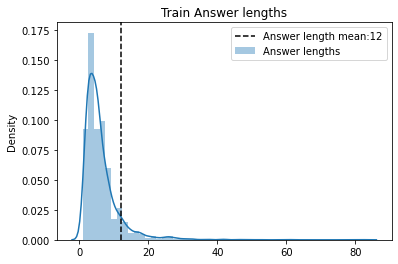

 가장 긴 대답은 83 개의 길이를, 평균 대답 길이는 6.275050607287449 개의 길이를, 가장 짧은 대답은 1 개의 길이를 가지고 있습니다.


In [82]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['answers'])

tt['answer_len'] = [len(i['text'][0]) for i in train['answers']]

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.answer_len.mean() + dataframe.answer_len.std()).astype(int)
    sns.distplot(tuple(dataframe.answer_len), hist=True, kde=True, label='Answer lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Answer length mean:{max_seq_len}')
    plt.title('Train Answer lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 대답은 {tt['answer_len'].max()} 개의 길이를, 평균 대답 길이는 {tt['answer_len'].mean()} 개의 길이를, 가장 짧은 대답은 {tt['answer_len'].min()} 개의 길이를 가지고 있습니다.")
plot_doc_lengths(tt)

## 5-3. answer 단어 갯수 분포

In [88]:
answers=[]
for item in train['answers']:
    k=''
    item=tokenize(item['text'][0])
    for i in item:
        k+=i+" "
    answers.append(k.strip())

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


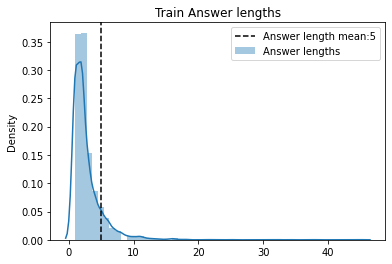

 가장 긴 대답은 45 개의 단어를, 평균 대답 단어 갯수는 2.7512651821862346 개의 단어를, 가장 짧은 대답은 1 개의 단어를 가지고 있습니다.


In [105]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tt = pd.DataFrame(columns=['answer'])

tt['answer_len'] = [len(i.split()) for i in answers]

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.answer_len.mean() + dataframe.answer_len.std()).astype(int)
    sns.distplot(tuple(dataframe.answer_len), hist=True, kde=True, label='Answer lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Answer length mean:{max_seq_len}')
    plt.title('Train Answer lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 대답은 {tt['answer_len'].max()} 개의 단어를, 평균 대답 단어 갯수는 {tt['answer_len'].mean()} 개의 단어를, 가장 짧은 대답은 {tt['answer_len'].min()} 개의 단어를 가지고 있습니다.")
plot_doc_lengths(tt)